# Predicting flight delays 

### Technical point of view 
- visualization: matplotlib, seaborn, basemap
- data manipulation: pandas, numpy
- modeling: sklearn, scipy
- class definition: regression, figures


## Overview of the dataset
First load all the packages that will be needed during this project. 

In [131]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# Working with Yearly Flight Data
When working with large datasets, it can be challenging to manage and share the data, especially when using platforms like GitHub, which have file size limits. In our case, we have a large dataset of flight information spanning an entire year. To manage this data effectively and share it on GitHub, we initially split the data into 12 separate CSV files, each representing a month of flight data.

# Combining the Data
While splitting the data has its advantages, there are times when it’s beneficial to work with the entire dataset at once. For example, we might want to perform an operation that requires data from all 12 months.

To do this, we can read each of the 12 CSV files and append them to a single DataFrame. This gives us a single DataFrame containing all the flight data for the year, which we can then work with as usual in pandas.

In [132]:
import pandas as pd

# Initialize an empty DataFrame
df_flights = pd.DataFrame()

# Loop over the 12 months
for i in range(1, 13):
    # Load the csv file of the current month
    df_month = pd.read_csv(f'../Dataset/split_datasets/flight_month_{i}.csv')
    
    # Append the data of the current month to the main DataFrame
    df_flights = df_flights._append(df_month)

# Now, df_flights contains the data of all 12 months


read the file that contains the details of all the flights that occured in 2015. I output some information concerning the types of the variables in the dataframe and the quantity of null values for each variable:

## Overview of the flights dataset's data types

In [133]:
# flights data for the first month (January)  

print('Dimension of flights dataframe: ', df_flights .shape)
#df_flights.head()

# gives some infos on columns types and numbers of null values
table_info= pd.DataFrame(df_flights.dtypes).T.rename(index={0: 'column type'})
table_info= table_info._append(pd.DataFrame(df_flights.isnull().sum()).T.rename(index= {0: 'number of null values'}))
table_info= table_info._append(pd.DataFrame(df_flights.isnull().sum()/df_flights.shape[0]*100).T.rename(index={0: 'null values in %'}))

table_info

Dimension of flights dataframe:  (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
number of null values,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values in %,0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


### Overview of the aiports dataset

In [134]:
aiports = pd.read_csv('../Dataset/archive-6/airports.csv')
aiports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


## Airports loaction on the map

To have a global overview of the geographical area covered in this dataset, we can plot the airports location and indicate the number of flights recorded during year 2015 in each of them:

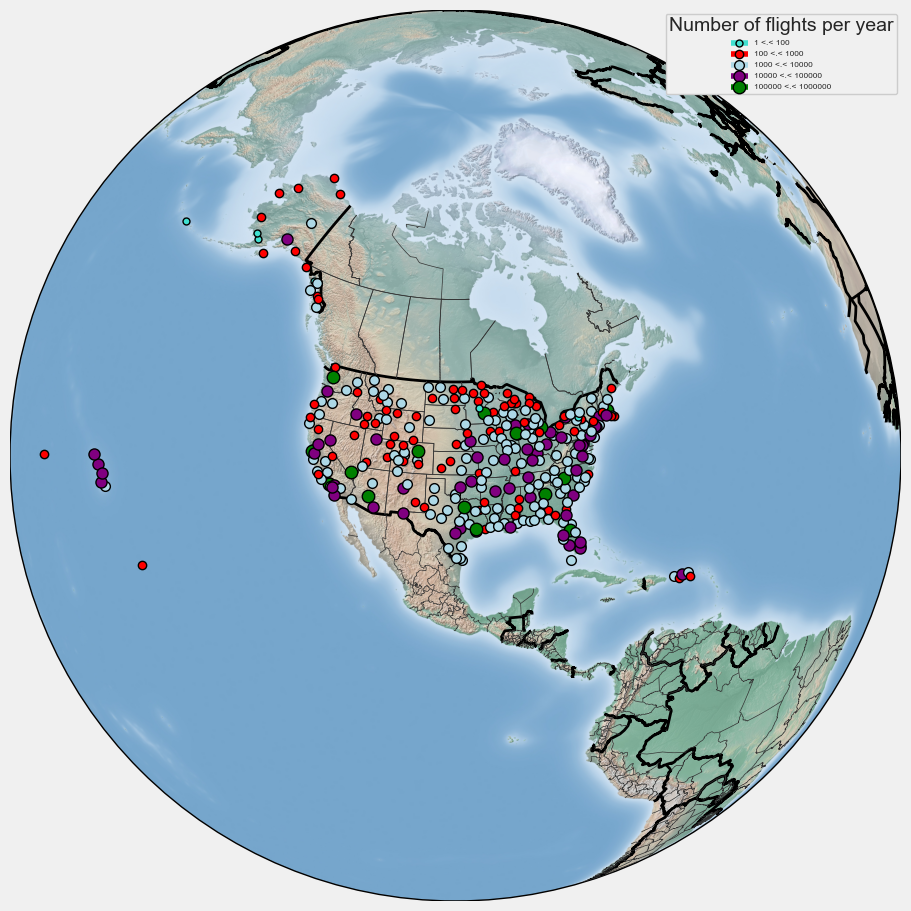

In [135]:
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()

plt.figure(figsize=(11,11))

########################################################################################################################## 
# define properties of markers and labels
colors = ['turquoise', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
########################################################################################################################## 
#resolution = 'i', install  basemap-data-hires for resolution='h' = high
map = Basemap(resolution='i', projection='ortho', lat_0=39.5, lon_0=-98.35)
map.shadedrelief()
map.drawcountries(linewidth=2)
map.drawstates(color='0.2')
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')

# put airports on map
for index, (airports_code, y,x) in aiports [['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x,y = map(x,y)
    isize=[i for i, val in enumerate(size_limits) if val < count_flights[airports_code]]
    ind= isize[-1]
    # markeredgecolor: k = black, ‘b'=blue, 'g'=green, 'm'=magenta ......
    # markertypes : 'o'= circle, 'D' and 'd' diamonds 
    map.plot(x,y, marker='o', markersize=ind+5, markeredgewidth=1, color=colors[ind], markeredgecolor='k', label=labels[ind])

# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size': 6},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()


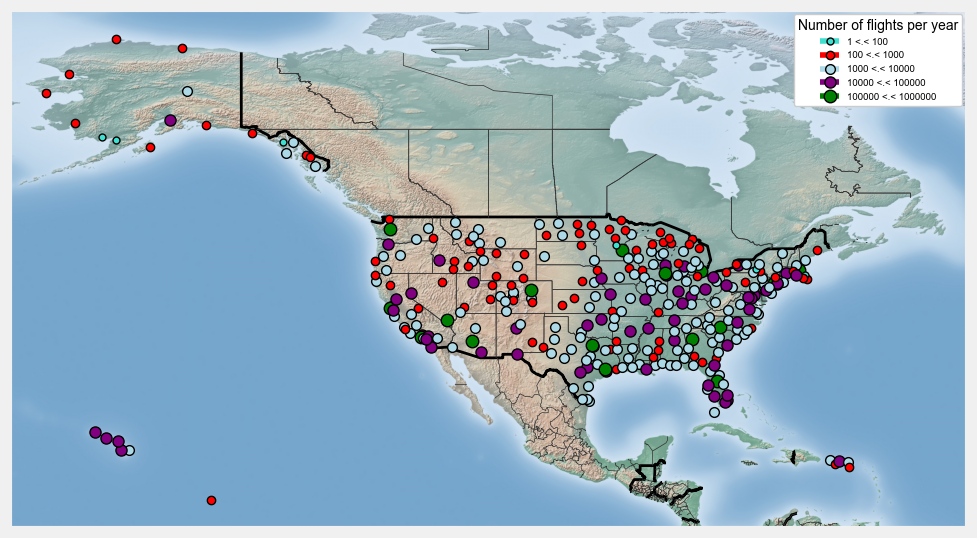

In [136]:
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()

plt.figure(figsize=(11,11))

########################################################################################################################## 
# define properties of markers and labels
colors = ['turquoise', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
########################################################################################################################## 
#resolution = 'i', install  basemap-data-hires for resolution='h' = high
map = Basemap(resolution='i', llcrnrlon=-170, urcrnrlon=-50, llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0)

map.shadedrelief()
map.drawcountries(linewidth=2)
map.drawstates(color='0.2')
########################################################################################################################## 

# put airports on map

for index, (airports_code, y,x) in aiports [['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x,y = map(x,y)
    isize=[i for i, val in enumerate(size_limits) if val < count_flights[airports_code]]
    ind= isize[-1]
    # markeredgecolor: k = black, ‘b'=blue, 'g'=green, 'm'=magenta ......
    # markertypes : 'o'= circle, 'D' and 'd' diamonds 
    map.plot(x,y, marker='o', markersize=ind+5, markeredgewidth=1, color=colors[ind], markeredgecolor='k', label=labels[ind])

########################################################################################################################## 

# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
legend = plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size': 7},
           title='Number of flights per year', frameon = True, framealpha = 1, fontsize=12, 
           title_fontsize=12)

legend.get_frame().set_facecolor('white')  # Set the legend background color to blue
legend.get_title().set_fontsize(10)  # Set the legend title size to 12
legend.get_title().set_color('black')
#legend.get_title().set_backgroundcolor('darkblue')  # Set the legend title background color to dark blue
plt.setp(legend.get_texts(), color='black')  # Set the color of the text to white

plt.show()

### Number of flights for Jan, Feb, Jun and July 

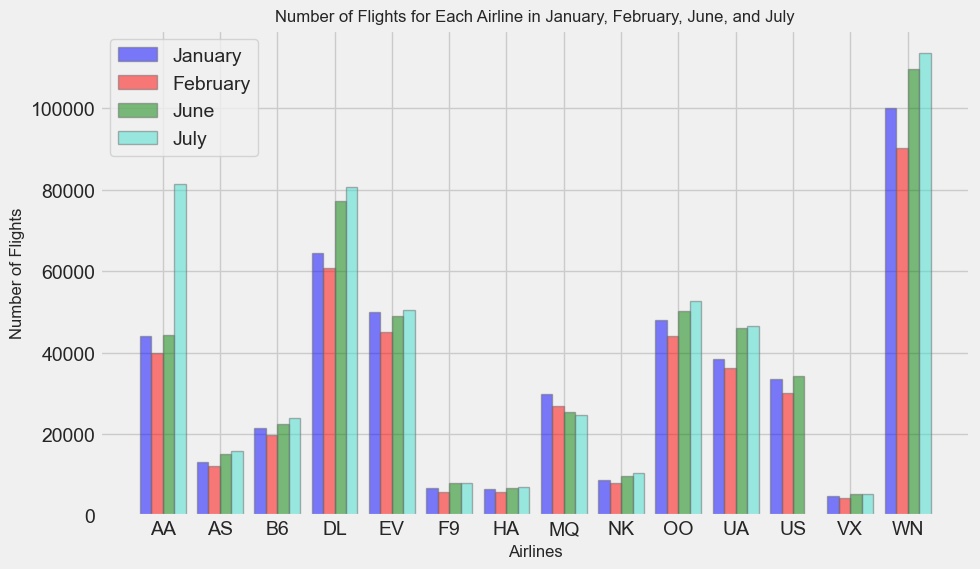

In [137]:

# Filter for January, February, June and July 
months_data = []
for month, month_name in zip([1, 2, 6, 7], ['January', 'February', 'June', 'July']):
    month_flights = df_flights[df_flights['MONTH'] == month]
    flights_per_airline = month_flights['AIRLINE'].value_counts()
    months_data.append(pd.DataFrame({'Airline': flights_per_airline.index, month_name: flights_per_airline.values}))

# Merge data for all months
all_data = months_data[0]
for month_data in months_data[1:]:
    all_data = pd.merge(all_data, month_data, on='Airline', how='outer')

all_data = all_data.fillna(0)  # Fill missing values with zeros

# creating the bar chart
plt.figure(figsize=(10,6))

# Define the width of the bars and the positions of the bar centers
bar_width = 0.2
r1 = np.arange(len(all_data))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot flights for each month
plt.bar(r1, all_data['January'].values, color='b', width=bar_width, alpha=0.5, label='January')
plt.bar(r2, all_data['February'].values, color='r', width=bar_width, alpha=0.5, label='February')
plt.bar(r3, all_data['June'].values, color='g', width=bar_width, alpha=0.5, label='June')
plt.bar(r4, all_data['July'].values, color='turquoise', width=bar_width, alpha=0.5, label='July')

plt.title('Number of Flights for Each Airline in January, February, June, and July',fontsize=12)
plt.xlabel('Airlines', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width*1.5 for r in range(len(all_data))], all_data['Airline'])

plt.legend()
plt.show()

## Pie chart for comparision of the numbers of flights for some months 

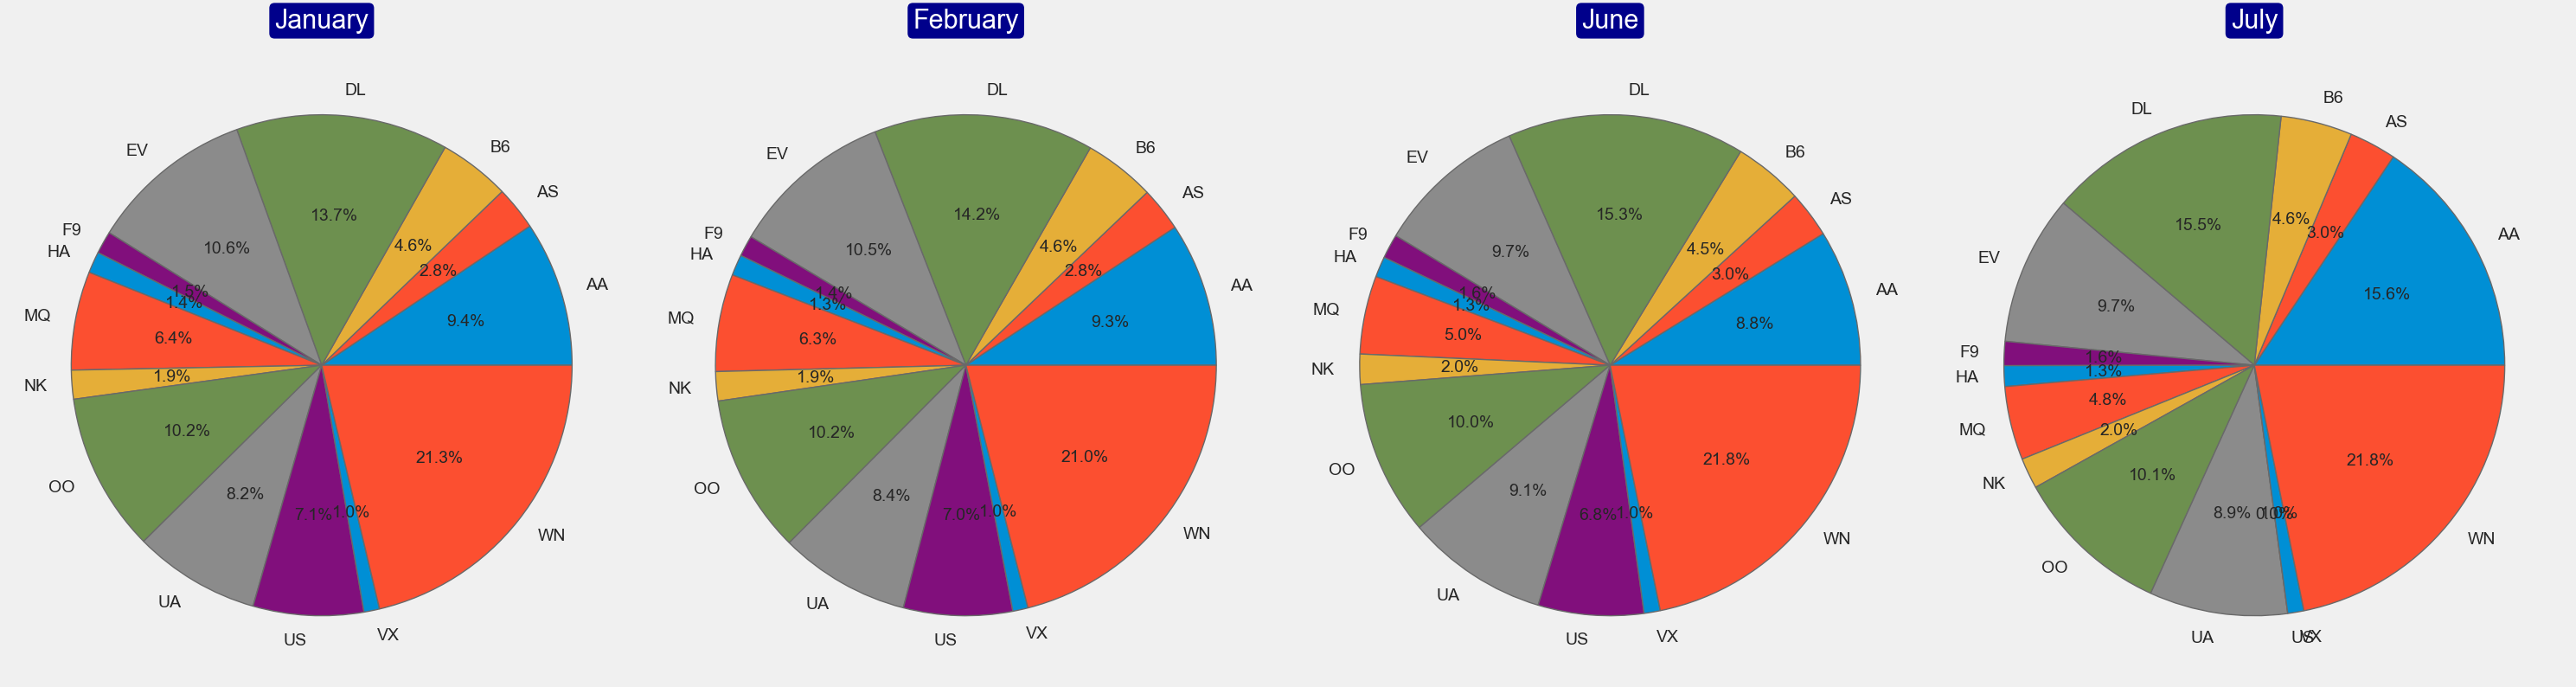

In [138]:
# Filter for January, February, June and July 
months_data = []
for month, month_name in zip([1, 2, 6, 7], ['January', 'February', 'June', 'July']):
    month_flights = df_flights[df_flights['MONTH'] == month]
    flights_per_airline = month_flights['AIRLINE'].value_counts()
    months_data.append(pd.DataFrame({'Airline': flights_per_airline.index, month_name: flights_per_airline.values}))

# Merge data for all months
all_data = months_data[0]
for month_data in months_data[1:]:
    all_data = pd.merge(all_data, month_data, on='Airline', how='outer')

all_data = all_data.fillna(0)  # Fill missing values with zeros

# Create a pie chart for each month
fig, axs = plt.subplots(1, 4, figsize=(30, 30))

months = ['January', 'February', 'June', 'July']
for i, ax in enumerate(axs.flat):
    ax.pie(all_data[months[i]], labels=all_data['Airline'], autopct='%1.1f%%')
    ax.set_title(months[i], fontsize=22, pad=20, color='white', bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()

# Ranking of Airlines with most flights

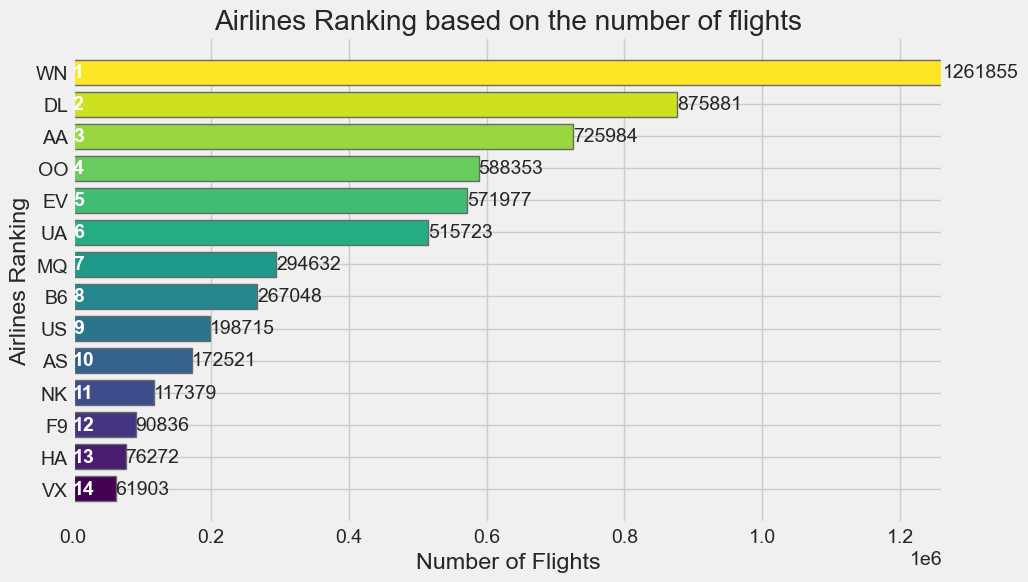

In [139]:
# Count the number of flights per airline for the entire year
flights_per_airline = df_flights['AIRLINE'].value_counts()

# Convert the Series to a DataFrame
ranking_table = flights_per_airline.reset_index()

# Rename the columns
ranking_table.columns = ['Airline', 'Number of Flights']

# Sort the airlines by the number of flights
ranking_table = ranking_table.sort_values('Number of Flights', ascending=True)

# Display the ranking table
# print(ranking_table)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))

# Generate a color array
colors = plt.cm.viridis(np.linspace(0, 1, len(ranking_table)))

bars = plt.barh(ranking_table['Airline'], ranking_table['Number of Flights'], color=colors)

# Add labels and title
plt.xlabel('Number of Flights')
plt.ylabel('Airlines Ranking')
plt.title('Airlines Ranking based on the number of flights')

# Add the number of flights for each airline on each bar
for i, bar in enumerate(reversed(bars)):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}', 
             va='center', ha='left')
    # Add ranking number
    plt.text(0, bar.get_y() + bar.get_height()/2, 
             f'{i+1}', 
             va='center', color='white', fontweight='bold', fontsize=14)

# Adjust the x-axis limits to prevent overlap between the ranking numbers and the airline names
plt.xlim(-10, max(ranking_table['Number of Flights']) + 10)

# Display the chart
plt.show()

In [140]:
df_flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479225,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.0,-4.0,22.0,17.0,320.0,298.0,272.0,2611,749.0,4.0,819,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
479226,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
479227,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
479228,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.0,-6.0,10.0,3.0,161.0,157.0,144.0,1189,327.0,3.0,340,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Distance flown per airline per year

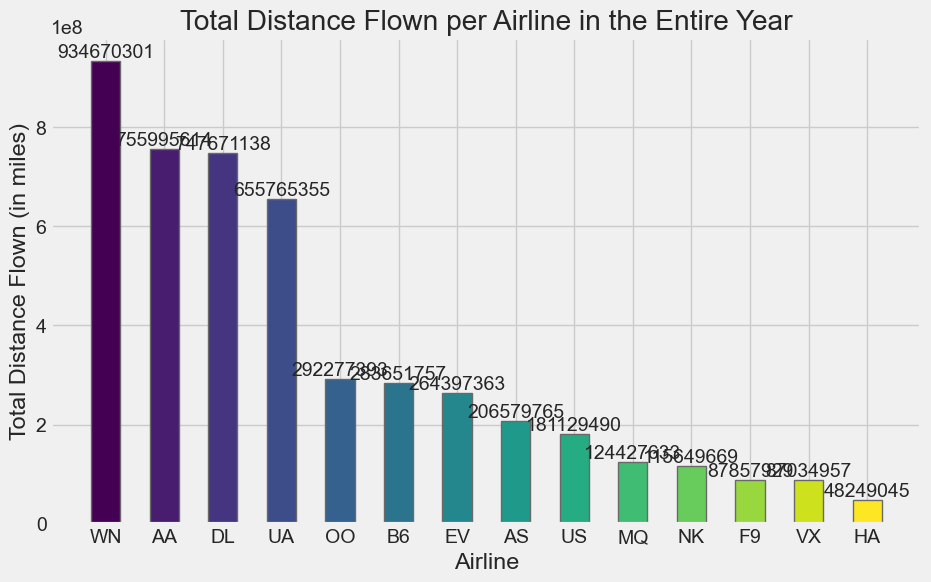

In [141]:
# Group by airline and calculate the total distance for each airline
total_distance_per_airline = df_flights.groupby('AIRLINE')['DISTANCE'].sum().reset_index()

# Sort the data by total distance in descending order
total_distance_per_airline = total_distance_per_airline.sort_values('DISTANCE', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))

# Generate a color array
colors = plt.cm.viridis(np.linspace(0, 1, len(total_distance_per_airline)))

# Create bars with different colors and narrower width
bars = plt.bar(total_distance_per_airline['AIRLINE'], total_distance_per_airline['DISTANCE'], color=colors, width=0.5)

# Add the total distance on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.0f}', 
             ha='center', va='bottom')

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Total Distance Flown (in miles)')
plt.title('Total Distance Flown per Airline in the Entire Year')

# Display the chart
plt.show()



# 1. Cleaning
1.1 Dates and times

In the initial dataframe, dates are coded according to 4 variables: **YEAR, MONTH, DAY**, and **DAY_OF_WEEK**. In fact, python offers the datetime format which is really convenient to work with dates and times and I thus convert the dates in this format:

In [142]:
df_flights['DATE'] = pd.to_datetime(df_flights[['YEAR','MONTH', 'DAY']])

In [143]:
df_flights.head(20)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,19.0,-6.0,11.0,30.0,181.0,170.0,154.0,1299,504.0,5.0,526,509.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,-11.0,17.0,36.0,195.0,193.0,173.0,1464,529.0,3.0,545,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,33.0,3.0,12.0,45.0,221.0,203.0,186.0,1747,651.0,5.0,711,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


### Drop the Columns that are not needed to reduce the size of dataframe and the calculations

In [144]:
df_flights.drop(['TAXI_OUT','AIR_SYSTEM_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIVERTED', 'WHEELS_OFF', 'WHEELS_ON', 'CANCELLATION_REASON', 'CANCELLED', 'AIRLINE_DELAY', 'SECURITY_DELAY', 'WEATHER_DELAY', 'TAXI_IN', 'YEAR','MONTH', 'DAY','DAY_OF_WEEK'], axis=1, inplace=True)


### Fill the NaNs with zeros 

In [145]:
df_flights.fillna(0, inplace=True)


In [146]:
df_flights

,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE
0,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,205.0,194.0,169.0,1448,430,408.0,-22.0,2015-01-01
1,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,280.0,279.0,263.0,2330,750,741.0,-9.0,2015-01-01
2,US,840,N171US,SFO,CLT,20,18.0,-2.0,286.0,293.0,266.0,2296,806,811.0,5.0,2015-01-01
3,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,285.0,281.0,258.0,2342,805,756.0,-9.0,2015-01-01
4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,235.0,215.0,199.0,1448,320,259.0,-21.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479225,B6,688,N657JB,LAX,BOS,2359,2355.0,-4.0,320.0,298.0,272.0,2611,819,753.0,-26.0,2015-12-31
479226,B6,745,N828JB,JFK,PSE,2359,2355.0,-4.0,227.0,215.0,195.0,1617,446,430.0,-16.0,2015-12-31
479227,B6,1503,N913JB,JFK,SJU,2359,2350.0,-9.0,221.0,222.0,197.0,1598,440,432.0,-8.0,2015-12-31
479228,B6,333,N527JB,MCO,SJU,2359,2353.0,-6.0,161.0,157.0,144.0,1189,340,330.0,-10.0,2015-12-31


In the *SCHEDULED_DEPARTURE* variable, the departure time is represented as a float. The first two digits denote the hour, and the last two represent the minutes. We’ll combine the departure hour with the flight date. To carry out these modifications, I’ll create several functions.

In [147]:
print(' SCHEDULED_DEPARTURE: ',df_flights['SCHEDULED_DEPARTURE'].dtype)
print(' DEPARTURE_TIME: ',df_flights['DEPARTURE_TIME'].dtype)
print(' SCHEDULED_ARRIVAL: ',df_flights['SCHEDULED_ARRIVAL'].dtype)
print(' ARRIVAL_TIME: ',df_flights['ARRIVAL_TIME'].dtype)
print(' DATE: ',df_flights['DATE'].dtype)

 SCHEDULED_DEPARTURE:  int64
 DEPARTURE_TIME:  float64
 SCHEDULED_ARRIVAL:  int64
 ARRIVAL_TIME:  float64
 DATE:  datetime64[ns]


## Convert to date and time 
1. Function that converts the 'HHMM' string to datetime.time
2. Function that combines a date and time to produce a datetime.datetime
3. Function that combines two columns of the dataframe to create a datetime format

In [148]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________

# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

### ====== Here is a Problem . The below cell takes too long to process ===== 

In [149]:
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(format_heure)

In [150]:
df_flights['DEPARTURE_TIME'] = df_flights['DEPARTURE_TIME'].apply(format_heure)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(format_heure)
df_flights['ARRIVAL_TIME'] = df_flights['ARRIVAL_TIME'].apply(format_heure)

In [151]:
df_flights

,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE
0,AS,98,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,169.0,1448,04:30:00,04:08:00,-22.0,2015-01-01
1,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,263.0,2330,07:50:00,07:41:00,-9.0,2015-01-01
2,US,840,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,286.0,293.0,266.0,2296,08:06:00,08:11:00,5.0,2015-01-01
3,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,258.0,2342,08:05:00,07:56:00,-9.0,2015-01-01
4,AS,135,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,199.0,1448,03:20:00,02:59:00,-21.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479225,B6,688,N657JB,LAX,BOS,23:59:00,23:55:00,-4.0,320.0,298.0,272.0,2611,08:19:00,07:53:00,-26.0,2015-12-31
479226,B6,745,N828JB,JFK,PSE,23:59:00,23:55:00,-4.0,227.0,215.0,195.0,1617,04:46:00,04:30:00,-16.0,2015-12-31
479227,B6,1503,N913JB,JFK,SJU,23:59:00,23:50:00,-9.0,221.0,222.0,197.0,1598,04:40:00,04:32:00,-8.0,2015-12-31
479228,B6,333,N527JB,MCO,SJU,23:59:00,23:53:00,-6.0,161.0,157.0,144.0,1189,03:40:00,03:30:00,-10.0,2015-12-31


df_flights

In [152]:
# Convert 'SCHEDULED_DEPARTURE' to string type
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].astype(str)

# Combine 'DATE' and 'SCHEDULED_DEPARTURE'
df_flights['SCHEDULED_DEPARTURE_'] = pd.to_datetime(df_flights['DATE'].astype(str) + ' ' + df_flights['SCHEDULED_DEPARTURE'])

# Now 'DATETIME' is a combined column in datetime format
df_flights

,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE,SCHEDULED_DEPARTURE_
0,AS,98,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,169.0,1448,04:30:00,04:08:00,-22.0,2015-01-01,2015-01-01 00:05:00
1,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,263.0,2330,07:50:00,07:41:00,-9.0,2015-01-01,2015-01-01 00:10:00
2,US,840,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,286.0,293.0,266.0,2296,08:06:00,08:11:00,5.0,2015-01-01,2015-01-01 00:20:00
3,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,258.0,2342,08:05:00,07:56:00,-9.0,2015-01-01,2015-01-01 00:20:00
4,AS,135,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,199.0,1448,03:20:00,02:59:00,-21.0,2015-01-01,2015-01-01 00:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479225,B6,688,N657JB,LAX,BOS,23:59:00,23:55:00,-4.0,320.0,298.0,272.0,2611,08:19:00,07:53:00,-26.0,2015-12-31,2015-12-31 23:59:00
479226,B6,745,N828JB,JFK,PSE,23:59:00,23:55:00,-4.0,227.0,215.0,195.0,1617,04:46:00,04:30:00,-16.0,2015-12-31,2015-12-31 23:59:00
479227,B6,1503,N913JB,JFK,SJU,23:59:00,23:50:00,-9.0,221.0,222.0,197.0,1598,04:40:00,04:32:00,-8.0,2015-12-31,2015-12-31 23:59:00
479228,B6,333,N527JB,MCO,SJU,23:59:00,23:53:00,-6.0,161.0,157.0,144.0,1189,03:40:00,03:30:00,-10.0,2015-12-31,2015-12-31 23:59:00


In [ ]:
print(df_flights.describe())  # Get summary statistics
sns.boxplot(x="Airport", y="Arrival_Delay", showmeans=True, data=df_flights)  # Check for outlier

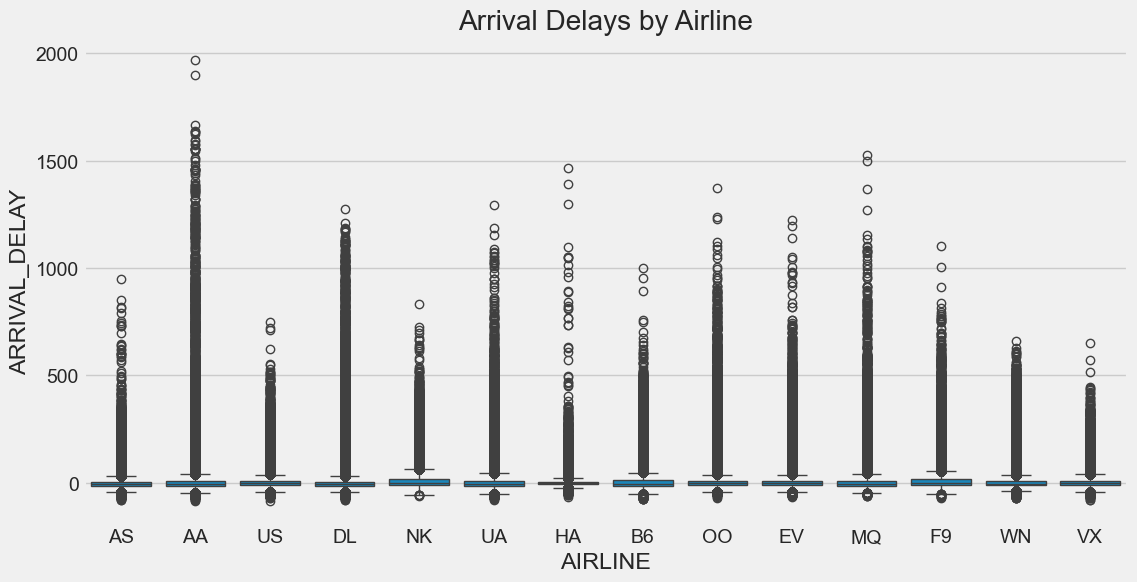

In [160]:
# 'AIRLINE' and 'ARRIVAL_DELAY'
plt.figure(figsize=(12,6))
sns.boxplot(x='AIRLINE', y='ARRIVAL_DELAY', data=df_flights)
plt.title('Arrival Delays by Airline')
plt.show()

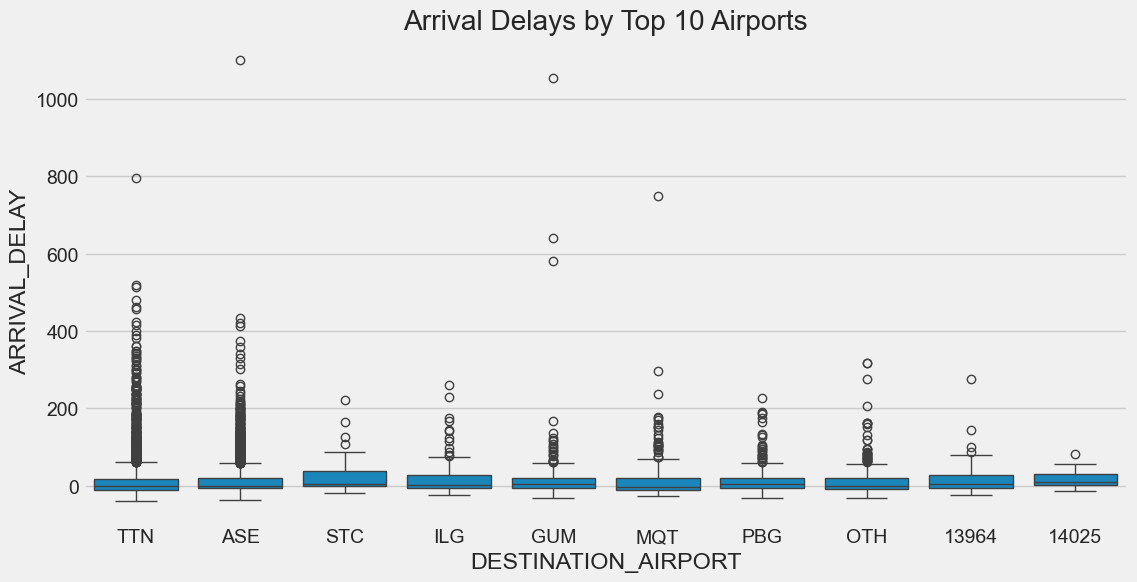

In [165]:
# Calculate average delay per airport
average_delay = df_flights.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean().reset_index()

# Sort by delay and select top 10
top_N = average_delay.sort_values(by='ARRIVAL_DELAY', ascending=False).head(10)

# Filter original DataFrame to include only top 10 airports
df_top_N = df_flights[df_flights['DESTINATION_AIRPORT'].isin(top_N['DESTINATION_AIRPORT'])]

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(x='DESTINATION_AIRPORT', y='ARRIVAL_DELAY', data=df_top_N)
plt.title('Arrival Delays by Top 10 Airports')
plt.show()
